# Task 1

In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [ ]:
# Enable autoreloading if import packages are changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Set up python path
import sys
import os
import cv2
import numpy as np
import torch
import math
import glob
import cv2 as cv
from math import sin, cos
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load images and keypoints

In [5]:
# Load images and keypoints
images = []
keypoints = []
for fname in glob.glob('images/*.jpg'):
    kps = np.loadtxt(fname.replace('.jpg', '-keypoints.txt'))
    keypoints.append(kps)
    img = cv.imread(fname)
    images.append(img)

    # plt.figure()
    # plt.imshow(img)
    # plt.plot(kps[:, 0], kps[:,1], 'rx')

# Prepare 3D object points of checker board like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objpoints = np.zeros((6*7,3), np.float32)
objpoints[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

## Q1 (Bonus): Normalize 2D and 3D points

In [6]:
# In slide 19, object points have homogenious coordinate 1
objpoints[:,2] = 1

In [9]:
def normalize(points):
    average_distance = np.sqrt(2.0)
    center_points = np.mean(points, axis=0)
    points_translated = points - center_points
    avg_distance_points = np.mean(np.linalg.norm(points_translated, axis=1))
    scale_factor_points = average_distance / avg_distance_points
    norm_T = np.array([[scale_factor_points, 0, -scale_factor_points * center_points[0]],
                        [0, scale_factor_points, -scale_factor_points * center_points[1]],
                        [0, 0, 1]])

    return norm_T

In [10]:
norm_keypoints, norm_kp_T = [], []
for i in range(10):
    # Keypoint transform and transformed keypoints
    norm_kp_T.append(normalize(keypoints[i])) # 3x3 transform to normalize points
    keypoints_hom = np.column_stack((keypoints[i], np.ones(len(keypoints[i]))))
    norm_keypoints.append(np.dot(keypoints_hom, norm_kp_T[i].T)[:, :2]) # Normalized keypoints for each image
norm_keypoints = np.array(norm_keypoints)


# Object points transform and transformed points
# (note: you can treat the 3D points as 2D points on the plane z=0)
norm_op_T = normalize(objpoints) # 3x3 transform to normalize points
norm_objpoints = np.dot(objpoints, norm_op_T.T)[:, :3] # Normalized object points

## Q2: Compute homography for each image

In [15]:
# Compute homographies
# See slide 21 of Lecture 4 Part B
N = objpoints.shape[0] # Number of points
A = np.zeros((2*N, 9))

homographies = [] # Computed homographies
for j in range(10):
    for i in range(N):
        x, y = norm_keypoints[j][i][0], norm_keypoints[j][i][1]
        X, Y = norm_objpoints[i][0], norm_objpoints[i][1]
        A[2*i, :] = [0,0,0, -X, -Y, -1 , y*X, y*Y, y]
        A[2*i + 1,:] = [X,Y,1,0,0,0,-x*X, -x*Y, -x]

    U, S, VT = np.linalg.svd(A.T@A)
    # Keep last row as h matrix
    h = VT[-1, :]
    H = np.reshape(h, (3,3))
    # Undo the normalisation of the homography matrices
    norm_kp_T_inv = np.linalg.inv(norm_kp_T[j])
    H_undo_norm = np.dot(np.dot(norm_kp_T_inv, H), norm_op_T)
    homographies.append(H_undo_norm)
    # Uncomment to use normalised homograpies
    # homographies.append(H)

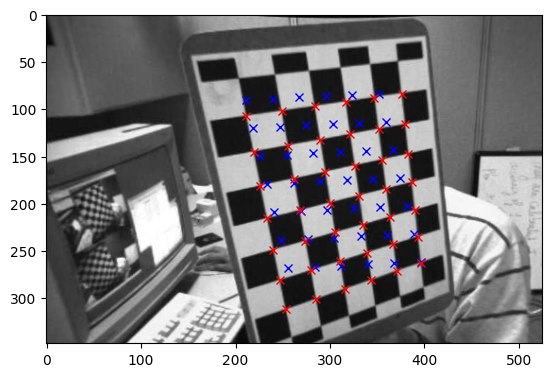

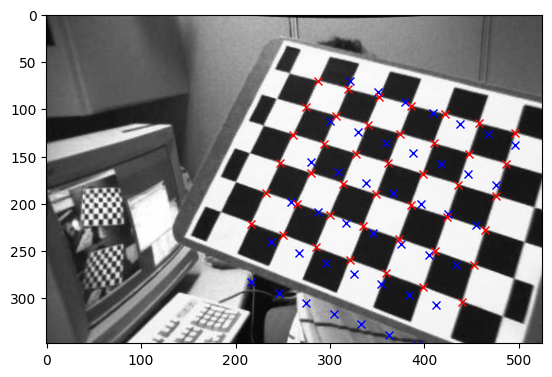

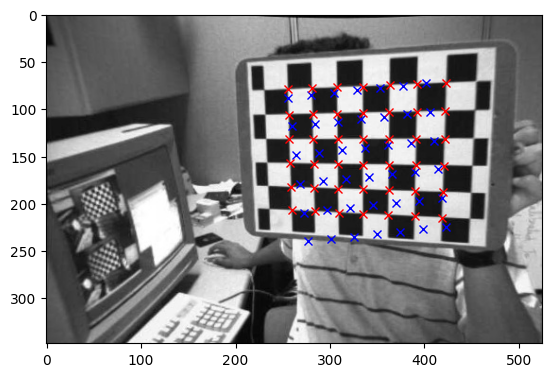

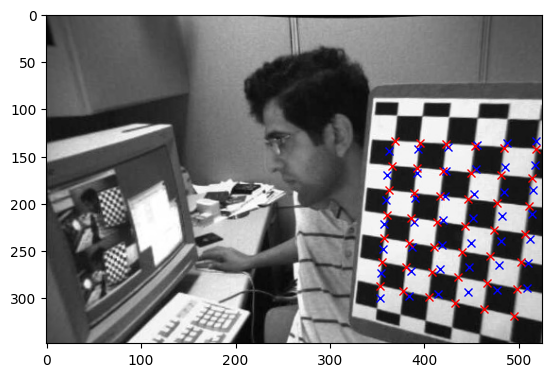

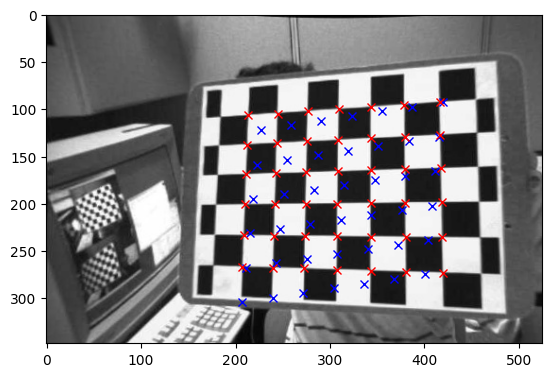

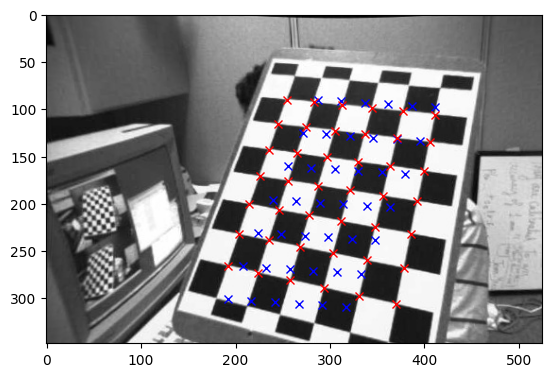

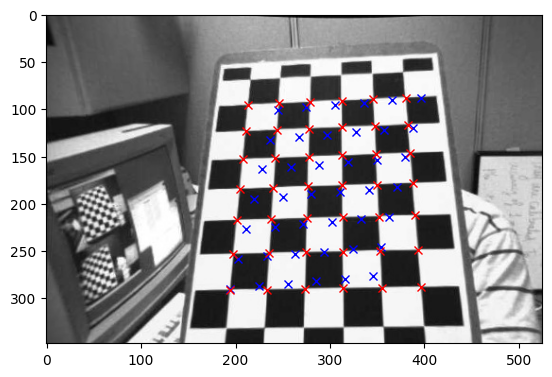

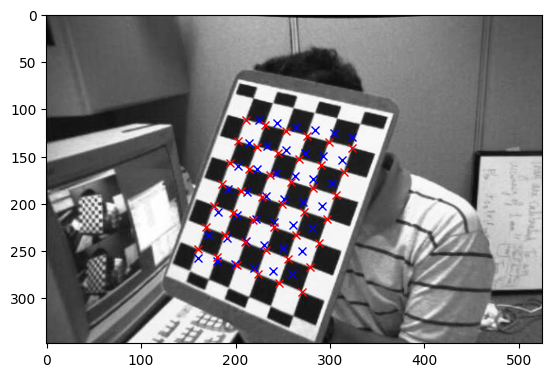

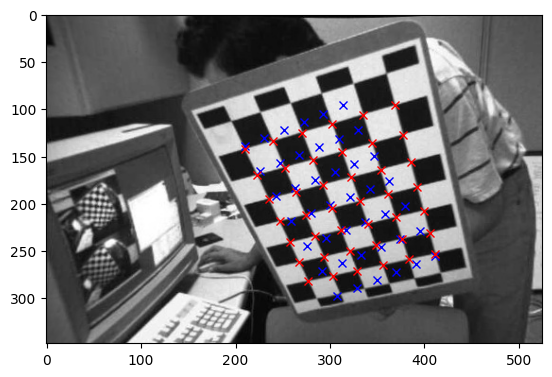

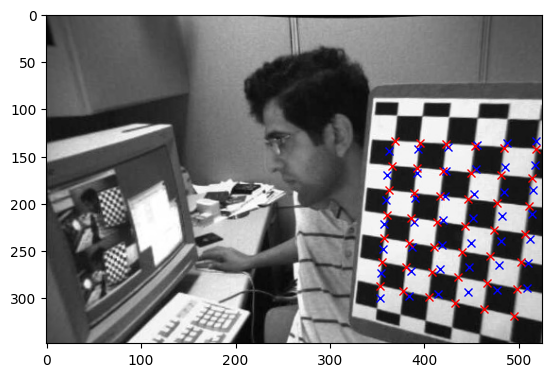

In [16]:
def normalize_transformed_points(transformed_points):
    trans_x = transformed_points[:, 0]
    trans_y = transformed_points[:, 1]
    # Find the minimum and maximum values for x and y
    min_x, max_x = np.min(trans_x), np.max(trans_x)
    min_y, max_y = np.min(trans_y), np.max(trans_y)
    # Normalize x and y coordinates
    norma_trans_x = (trans_x - min_x) / (max_x - min_x)
    norm_trans_y = (trans_y - min_y) / (max_y - min_y)
    # Replace the original x and y coordinates with normalized values
    norm_trans_points = np.column_stack((norma_trans_x, norm_trans_y))
    return norm_trans_points

# Check your homographies by taking the object points and projecting them to the images
for i in range(10):
    H = homographies[i]
    transformed_points = np.dot(H, objpoints.T).T
    # Make points (x and y) be between 0 and 1
    norm_transformed_points = normalize_transformed_points(transformed_points)
    # Calculate keypoints width and height
    kp_width = np.max(keypoints[i][:, 0]) - np.min(keypoints[i][:, 0])
    kp_height =  np.max(keypoints[i][:, 1]) - np.min(keypoints[i][:, 1])

    # Scale transformed points
    match_transformed_points_x = norm_transformed_points[:, 0]*kp_width
    match_transformed_points_y =  norm_transformed_points[:, 1]*kp_width

    # Sum the offset to match the shape
    match_transformed_points_x = match_transformed_points_x + np.min(keypoints[i][:, 0])
    match_transformed_points_y = match_transformed_points_y + np.min(keypoints[i][:, 1])

    match_transformed_points = np.column_stack((match_transformed_points_x, match_transformed_points_y))

    # Plot the transformed points and the keypoints
    plt.plot(match_transformed_points[:, 0], match_transformed_points[:, 1], 'bx')
    plt.plot(keypoints[i][:, 0], keypoints[i][:,1], 'rx')
    plt.imshow(images[i])
    plt.show()


## Q3: Compute calibration matrix and extrinsics

In [19]:
# Compute matrix B
# (see slide 25 of Lecture 4 Part B)
homographies = np.array(homographies)
n = len(homographies)
A = np.zeros((2*n, 6))

for i in range(n):
    H = homographies[i]

    # Extract elements of the homography matrix
    h11, h12, h13 = H[0, 0], H[0, 1], H[0, 2]
    h21, h22, h23 = H[1, 0], H[1, 1], H[1, 2]
    h31, h32, h33 = H[2, 0], H[2, 1], H[2, 2]
    # Construct the vectors v12 and (v11 - v22)
    v12 = np.array([h11 * h21, h11 * h22 + h12 * h21, h12 * h22, h13 * h21 + h11 * h23, h13 * h22 + h12 * h23, h13 * h23])
    v11_minus_v22 = np.array([h11**2 - h21**2, h11 * h12 + h12 * h11 - h21 * h22 - h22 * h21, h12**2 - h22**2,
                              h13 * h11 - h11 * h13 - h23 * h21 + h21 * h23, h13 * h12 - h12 * h13 - h23 * h22 + h22 * h23, h13**2 - h23**2])

    A[2 * i, :] = v12
    A[2 * i + 1, :] = v11_minus_v22

# Solve the system Ab = 0 using SVD
U, S, Vt = np.linalg.svd(A)
b = Vt[-1, :]
print(A.shape)
print(b)

# Compute K
# (see slide 26 of Lecture 4 Part B)
# Hint: the first row of K should be: 24.69157096, 5.41685322, -20.44468869
# Hint: don't forget to normalize to have the lower right entry to be 1
B11 = b[0]
B12 = b[1]
B22 = b[2]
B13 = b[3]
B23 = b[4]
B33 = b[5]

oy = (B12 * B13 - B11 * B23) / (B11 * B22 - B12**2)
print("oy:", oy)

lambda_val = B33 - (B13**2 + oy * (B12 * B13 - B11 * B23)) / B11
print("lambda:", lambda_val)

cx = np.sqrt((lambda_val / B11))
print("cx:", cx)

cy = np.sqrt(lambda_val * B11) /((B11 * B22 - B12**2))
print("cy:", cy)


tau = - (B12 * cx**2 * cy) / lambda_val
print("tau:", tau)

ox = (tau * oy) / cy - (B12 * cx**2) / lambda_val
print("ox:", ox)

K = np.array([[cx/lambda_val, tau/lambda_val, ox/lambda_val],
              [0, cy/lambda_val, oy/lambda_val],
              [0, 0, 1]])

print('K:')
print(K)
# Compute extrinsics and projection matrices
# (see slide 27 of Lecture 4 Part B)

(20, 6)
[0.67724918 0.12509594 0.72425307 0.0307348  0.01363651 0.00338606]
oy: -0.011352027767128476
lambda: 0.0019009064530051047
cx: 0.052979289299659414
cy: 0.07556095556938829
tau: -0.013957003042135012
ox: -0.18261498484337535
K:
[[ 27.87053998  -7.34228821 -96.06731807]
 [  0.          39.74996005  -5.97190238]
 [  0.           0.           1.        ]]


In [31]:
# Compute extrinsics and projection matrices
# for extrinsic matrices
n = 10
j = 0
e = [] # extrinsic matrix
p = [] # projection matrix
for i in range(n):

  h1 = homographies[i][j]
  h2 = homographies[i][j+1]
  h3 = homographies[i][j+2]

  K_inv = np.linalg.inv(K)

  if np.any(K_inv == 0):
      K_inv += 0.00001

  param = 1/np.linalg.norm(K_inv * h1)
  r1 = np.dot(param * K_inv, h1)
  r2 = np.dot(param * K_inv , h2)
  r3 = np.cross(r1, r2)
  t = np.dot(param * K_inv , h3)


  R = np.vstack((r1, r2, r3))
  # referring slide 27 - says R.T * R = 1, we suppose this means det(R.T * R) = 1
  det1 = np.linalg.det(np.dot(R, R.T))
  U, D, V = np.linalg.svd(R)
  res = np.dot(U, np.dot(np.eye(3), V))
  det2 = np.linalg.det(np.dot(res, res.T))

  # we don't need r3 in our extrinsic matrix.
  e = np.vstack((r1, r2, t))
  p.append(np.array(K@e@objpoints.T).T)
# calc projection matrices
# print(p)
print(len(p))# (see slide 27 of Lecture 4 Part B)

10


In [32]:
print(np.array(p[0]).shape)

(42, 3)


## Q4: Project 3D points and compute error to original keypoints

In [33]:
# Project object points for all images using K and respective extrinsics
# Visualize and commpute average error of projections to orignal keypoints
errors = []
for i in range(10):
  for j in range(42):
    error = np.mean(np.abs(p[i][j] - objpoints[j]))
    errors.append(error)
print('overall error:', np.mean(np.array(errors)))

overall error: 64.12534793022539
